# Gerando polígonos de vias por setor fiscal município de São Paulo

Esse notebook tem a intenção de ir um pouco além do último Notebook no sentido de avançar para um processamento viável para a publicação de uma nova camada no [Geosampa](http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/_SBC.aspx) 

Para isso vamos utilizar as seguintes camadas, recortadas por um setor fiscal definido para testes

* [Logradouros](http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadIfr.aspx?orig=DownloadCamadas&arq=05_Sistema%20Vi%E1rio%5C%5CLogradouro%5C%5CShapefile%5C%5CSIRGAS_SHP_logradouronbl&arqTipo=Shapefile)
* [Quadras Fiscais](http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadIfr.aspx?orig=DownloadCamadas&arq=11_Cadastro%5C%5CQuadra%5C%5CShapefile%5C%5CSIRGAS_SHP_quadraMDSF&arqTipo=Shapefile)
* [Quadras Viárias](http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadIfr.aspx?orig=DownloadCamadas&arq=05_Sistema%20Vi%E1rio%5C%5CQuadra%20Viaria%5C%5CShapefile%5C%5CSIRGAS_SHP_quadraviariaed&arqTipo=Shapefile)

Para nossos primeiros experimentos vamos utilizar o setor fiscal de número 037:

* [Setores Fiscais](http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadIfr.aspx?orig=DownloadCamadas&arq=11_Cadastro%5C%5CSetor%5C%5CShapefile%5C%5CSIRGAS_SHP_setorfiscal&arqTipo=Shapefile)

Os arquivos baixados nos links acima devem ser descompactados e colocados na pas `gis` deste repositório para funcioarem de acordo com os scripts a seguir.


## Trabalhando com o Geopandas

O Geopandas é um projeto de código aberto escrito em Python, possui bastante maturidade, eficácia e performance para trabalhar com grandes quantidade de dados. Ele usa o Pandas, NumPy e Shapely para trabalhar com dados georeferenciados e portanto achamos oportuno usa-lo.

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (40, 30)

df_qf = gpd.read_file(f'gis/SIRGAS_SHP_quadraMDSF.shp')
df_qv = gpd.read_file(f'gis/SIRGAS_SHP_quadraviariaed_polygon.shp')
df_l = gpd.read_file(f'gis/SIRGAS_SHP_logradouronbl.shp')
df_s = gpd.read_file(f'gis/SIRGAS_SHP_setorfiscal.shp')
# df_s = gpd.read_file(f'gis/SIRGAS_SHP_prefeitura_regional_polygon.shp')
# df_s = gpd.read_file(f'gis/SIRGAS_SHP_distrito_polygon.shp')
df_represas = gpd.read_file(f'gis/SIRGAS_REPRESAS_NIVELMAX.shp')
df_massa_dagua = gpd.read_file(f'gis/SIRGAS_MASSADAGUA.shp')

In [4]:
# df_s = df_s[df_s.ds_codigo == '23']
df_s = df_s.query("st_codigo == '037'")

In [5]:
df_s_sindex = df_s.sindex
df_l_sindex = df_l.sindex

In [6]:
# Get the bounding box coordinates of the Polygon as a list
bounds = list(df_s.bounds.values[0])

# Get the indices of the Points that are likely to be inside the bounding box of the given Polygon
l_candidate_idx = list(df_l_sindex.intersection(bounds))
l_candidates = df_l.loc[l_candidate_idx]

In [7]:
%time df_l = gpd.clip(l_candidates, df_s)

/home/fernando/miniconda3/envs/geo_env/lib/python3.8/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


CPU times: user 563 ms, sys: 16.1 ms, total: 579 ms
Wall time: 578 ms


In [8]:
# Removendo área de represa
df_s = gpd.overlay(df_s, df_represas, how='difference')

In [9]:
# Removendoo Massa dagua
df_s = gpd.overlay(df_s, df_massa_dagua, how='difference')

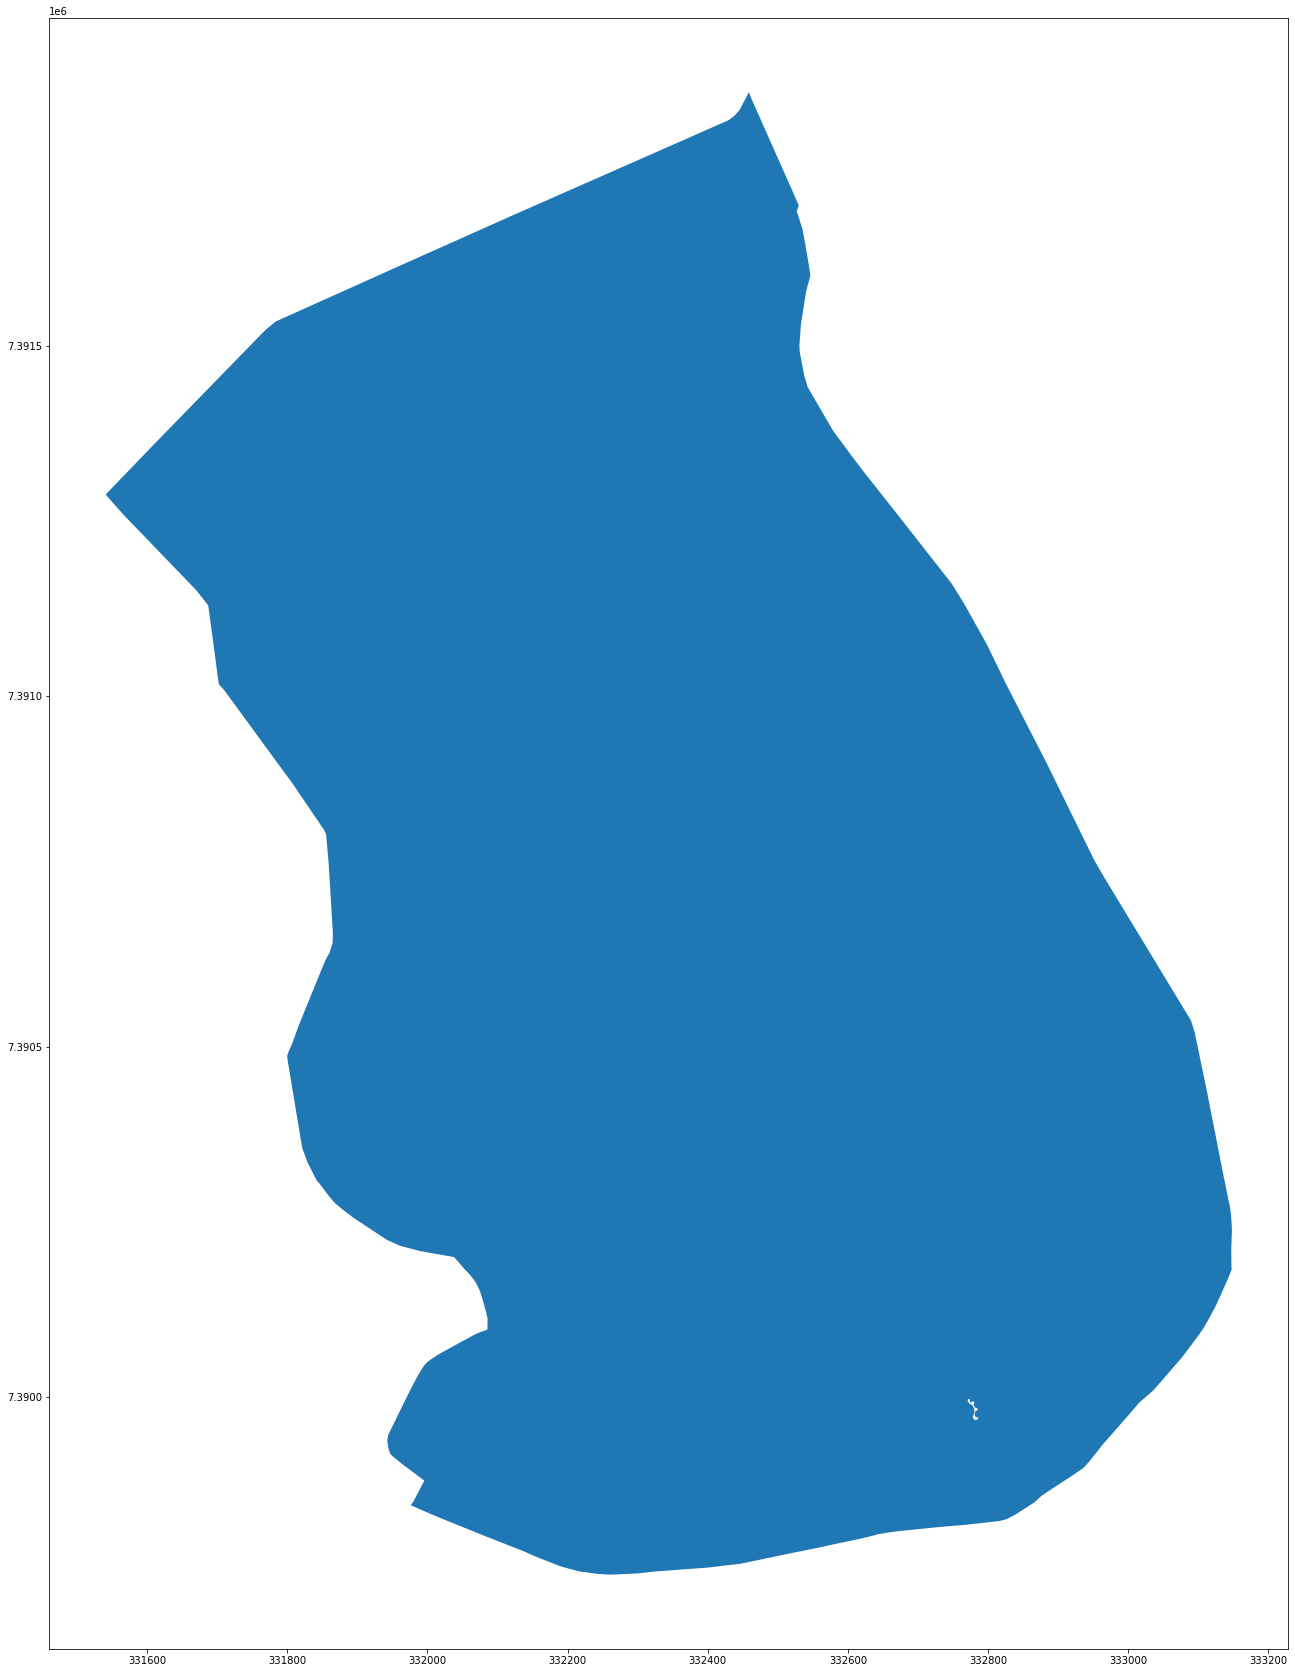

In [10]:
df_s.plot()

In [11]:
df_qv_sindex = df_qv.sindex

In [12]:
# Get the bounding box coordinates of the Polygon as a list
bounds = list(df_s.bounds.values[0])

# Get the indices of the Points that are likely to be inside the bounding box of the given Polygon
qv_candidate_idx = list(df_qv_sindex.intersection(bounds))
qv_candidates = df_qv.loc[qv_candidate_idx]

In [13]:
%time df_vias = gpd.overlay(df_s, qv_candidates, how='difference')

CPU times: user 1.21 s, sys: 2 µs, total: 1.21 s
Wall time: 1.21 s


In [14]:
## TODO
# Crop nas linhas das vias para manter apenas as que estão dentro de df_vias
%time df_l_cropped = gpd.clip(l_candidates, df_vias)

CPU times: user 974 ms, sys: 14 µs, total: 974 ms
Wall time: 973 ms


/home/fernando/miniconda3/envs/geo_env/lib/python3.8/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


In [15]:
df_l = df_l_cropped

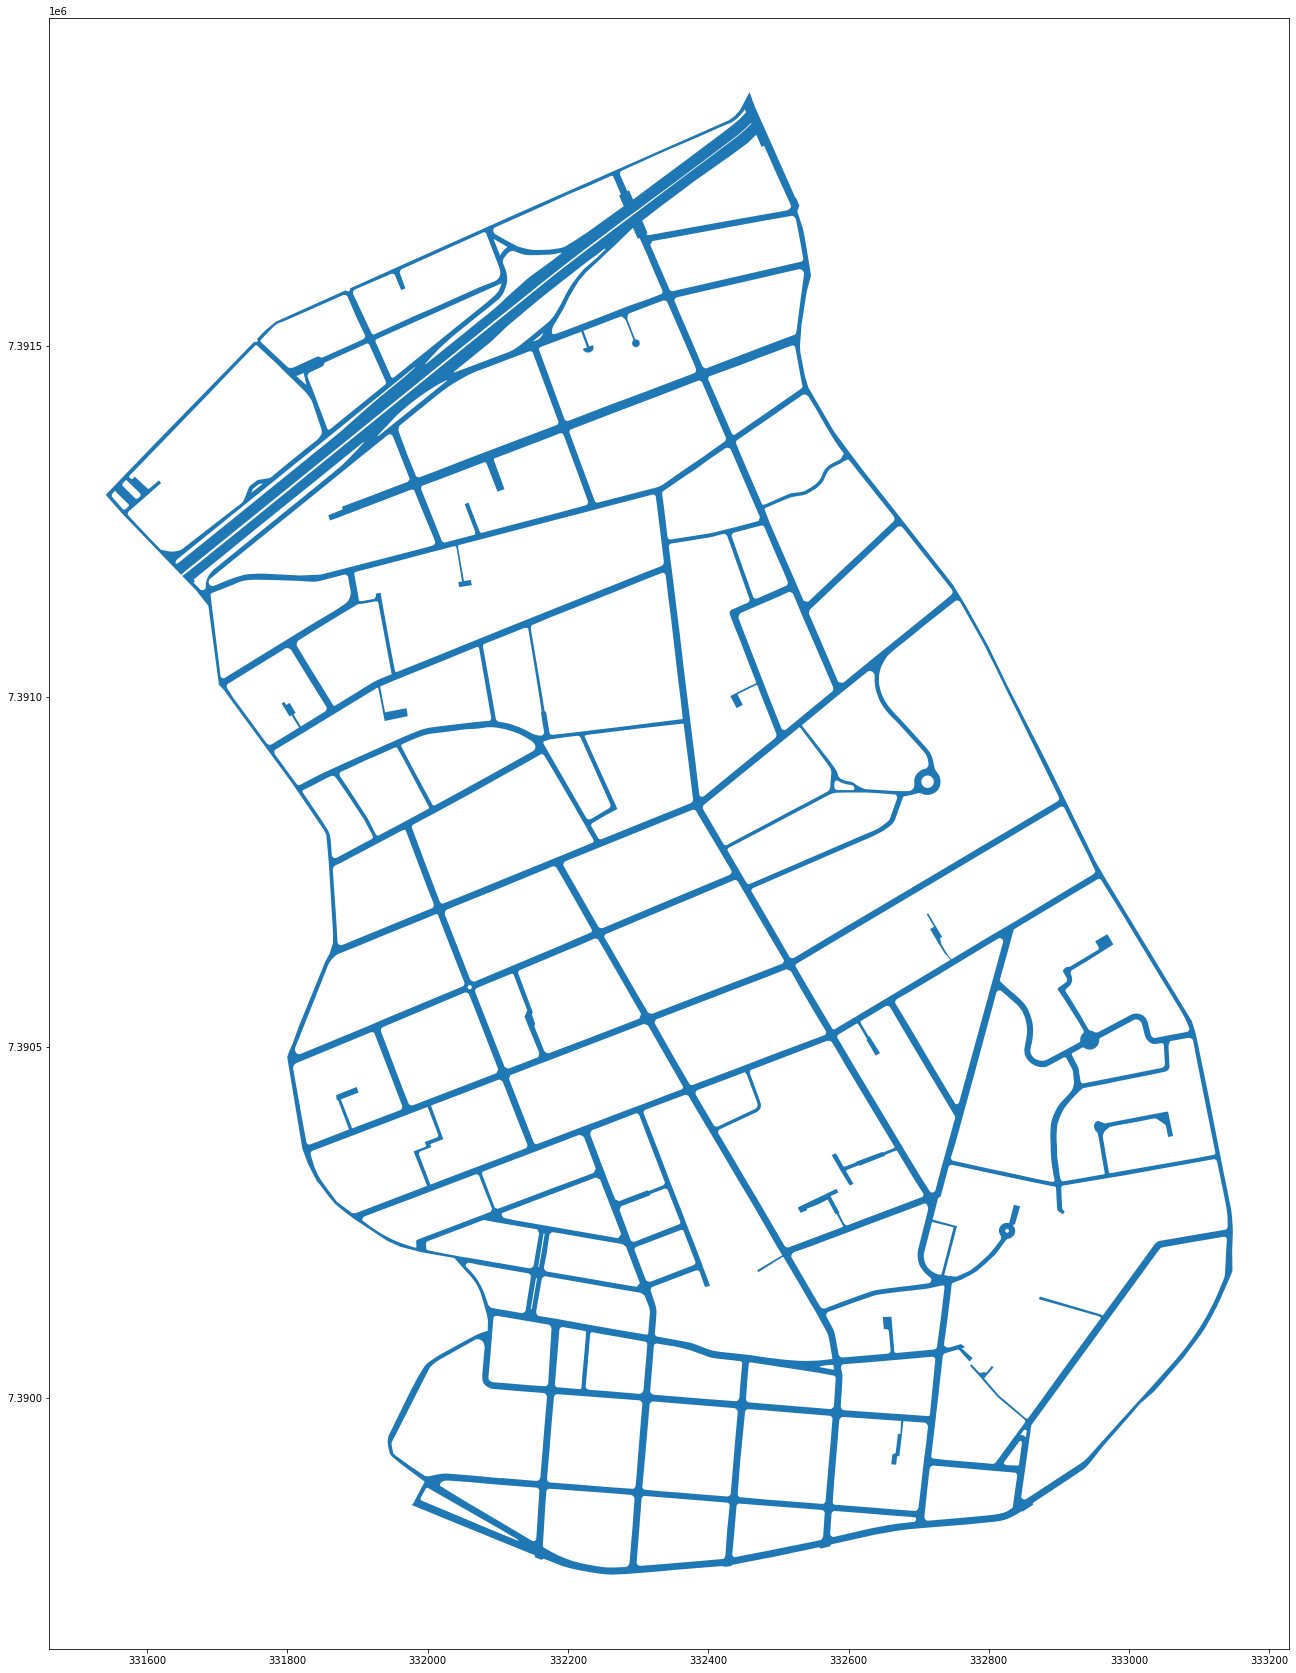

In [16]:
# Removendo área de massa dágua
df_vias[df_vias.disjoint(df_massa_dagua.unary_union)].plot()

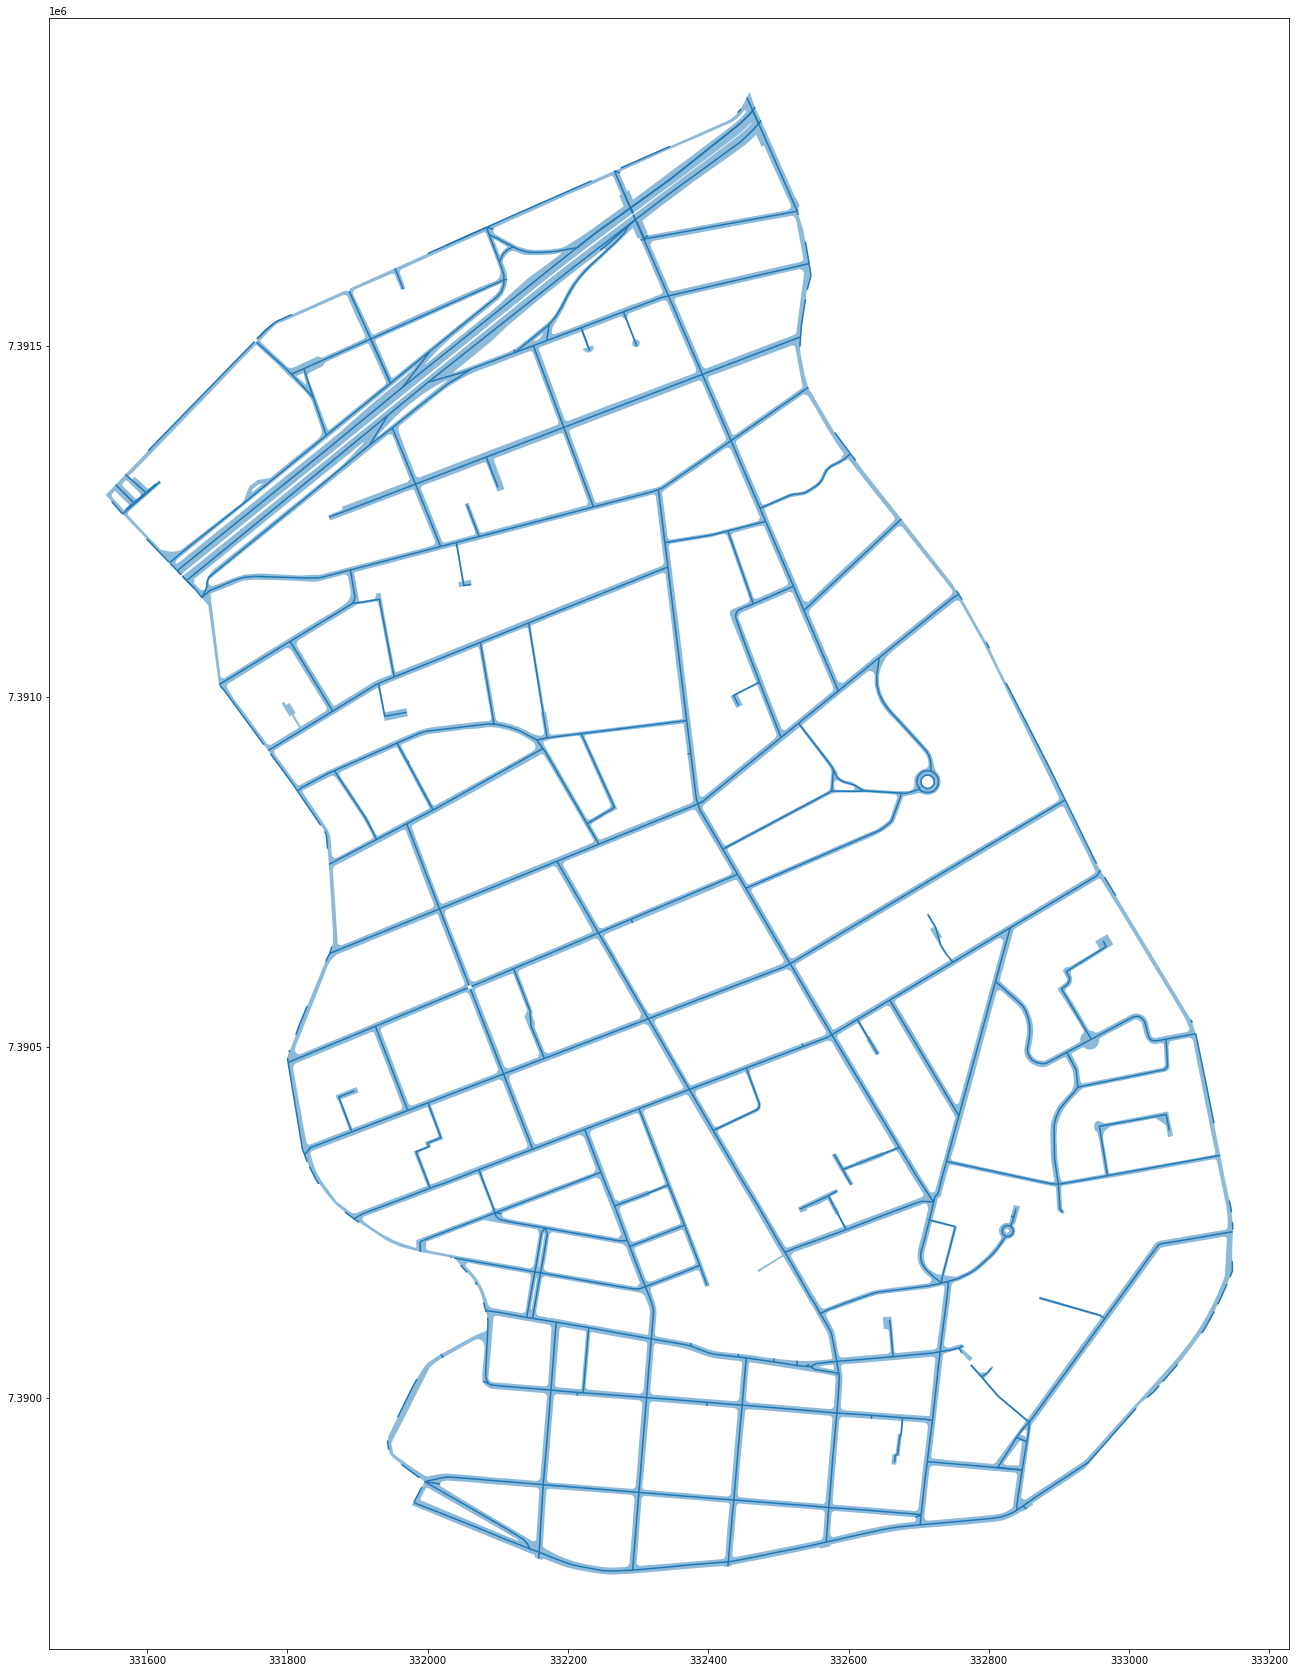

In [17]:
f, ax = plt.subplots(1)
df_vias.plot(ax=ax, alpha=0.5)
df_l.plot(ax=ax)
# df_logradouros.plot(ax=ax)

plt.show()

In [18]:
df_vias_buffered = df_vias.buffer(0.1)

In [19]:
df_l[df_l['geometry'].type != 'LineString']['geometry']

42032     MULTILINESTRING Z ((332546.395 7391600.248 0.0...
59128     MULTILINESTRING Z ((332526.860 7391691.825 0.0...
105095    MULTILINESTRING Z ((332288.937 7391696.586 0.0...
105094    MULTILINESTRING Z ((332288.937 7391696.586 0.0...
42036     MULTILINESTRING Z ((332757.038 7391145.939 0.0...
122939    MULTILINESTRING Z ((331814.408 7390865.179 0.0...
32738     MULTILINESTRING Z ((331642.871 7391179.411 0.0...
32734     MULTILINESTRING Z ((331642.871 7391179.411 0.0...
8680      MULTILINESTRING Z ((332085.588 7390095.870 0.0...
8685      MULTILINESTRING Z ((332082.550 7390125.270 0.0...
8681      MULTILINESTRING Z ((331845.059 7390305.563 0.0...
93894     MULTILINESTRING Z ((331800.890 7390478.364 0.0...
189139    MULTILINESTRING Z ((333035.383 7390009.153 0.0...
42034     MULTILINESTRING Z ((333069.113 7390047.932 0.0...
165466    MULTILINESTRING Z ((332757.411 7390071.306 0.0...
42038     MULTILINESTRING Z ((333147.253 7390181.244 0.0...
42024     MULTILINESTRING Z ((333142.814

Obtendo os pontos finais e iniciais de cada logradouro podemos saber onde as ruas começam e terminam

In [20]:
%time 
gdf_cruzamentos_inicio = df_l[df_l['geometry'].type == 'LineString']['geometry'].map(lambda x: (x.interpolate(0, normalized=True)))
gdf_cruzamentos_final = df_l[df_l['geometry'].type == 'LineString']['geometry'].map(lambda x: (x.interpolate(1, normalized=True)))
gdf_cruzamentos =  pd.concat([gdf_cruzamentos_inicio, gdf_cruzamentos_final])
gdf_c = gdf_cruzamentos

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 18.8 µs


Como alguns pontos acabam ficando muito próximos, seria interessante agregar todos os pontos do cruzamento.

In [21]:
%time
cruzamentos = [p.centroid for p in gdf_c.buffer(4).unary_union]
df_cruzamentos = gpd.GeoDataFrame(geometry=cruzamentos)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


In [22]:
%time
df_pts = gpd.GeoDataFrame(geometry=df_cruzamentos.buffer(10).boundary.intersection(df_l.unary_union))
# filtrando somente os multipontos
df_cruzamentos = df_cruzamentos[df_pts.geometry.type == 'MultiPoint']
df_pts = df_pts[df_pts.geometry.type == 'MultiPoint']

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


In [23]:
# unir pontos e o ponto central do cruzamento
%time
df_cruzamentos['id'] = df_cruzamentos.index.values
df_pts['id'] = df_pts.index.values
df_pt_pts = df_cruzamentos.merge(df_pts, on='id', suffixes=('_cruzamento', '_pt'))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.05 µs


In [24]:
# Calcular o angulo para cada ponto de intersecção
# e calcular a mediatriz desse pontos
%time

import numpy as np

def calc_angulos(i):
    c_x, c_y = i.geometry_cruzamento.coords[0]
    coords = list(map(lambda x: x.coords[0], i.geometry_pt.geoms))
    p_x = np.array(list(map(lambda x: x[0], coords)))
    p_y = np.array(list(map(lambda x: x[1], coords)))
    delta_x, delta_y = [p_x - c_x, p_y - c_y]
    # Colocar os pontos em ordem de angulo
    angle = np.sort(np.arctan2(delta_x, delta_y) - 0.5 * np.pi)
    angle_normalized = angle / (np.pi * 2) + 0.75
    angle_plus = np.append(angle_normalized, 1 + angle_normalized[0:1])
    points = angle_normalized + (np.diff(angle_plus) / 2)
    points[-1] = points[-1] - 1
    return list(points)

angles = list(map(lambda x: calc_angulos(x), df_pt_pts.itertuples()))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


In [25]:
%time
df_bounds = gpd.GeoDataFrame(geometry=df_cruzamentos.buffer(10).boundary)
df_bounds['angles'] = angles
# angles

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [26]:
%time
from shapely.geometry import MultiPoint

inter_points = list(map(
    lambda x: MultiPoint(list(map(
        lambda y: x.geometry.interpolate(y - 0.75, normalized=True), 
#         lambda y: x.geometry.interpolate(0.85, normalized=True),
        x.angles))), 
    df_bounds.itertuples()))

df_inter_points = gpd.GeoDataFrame(geometry=inter_points)

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 18.6 µs


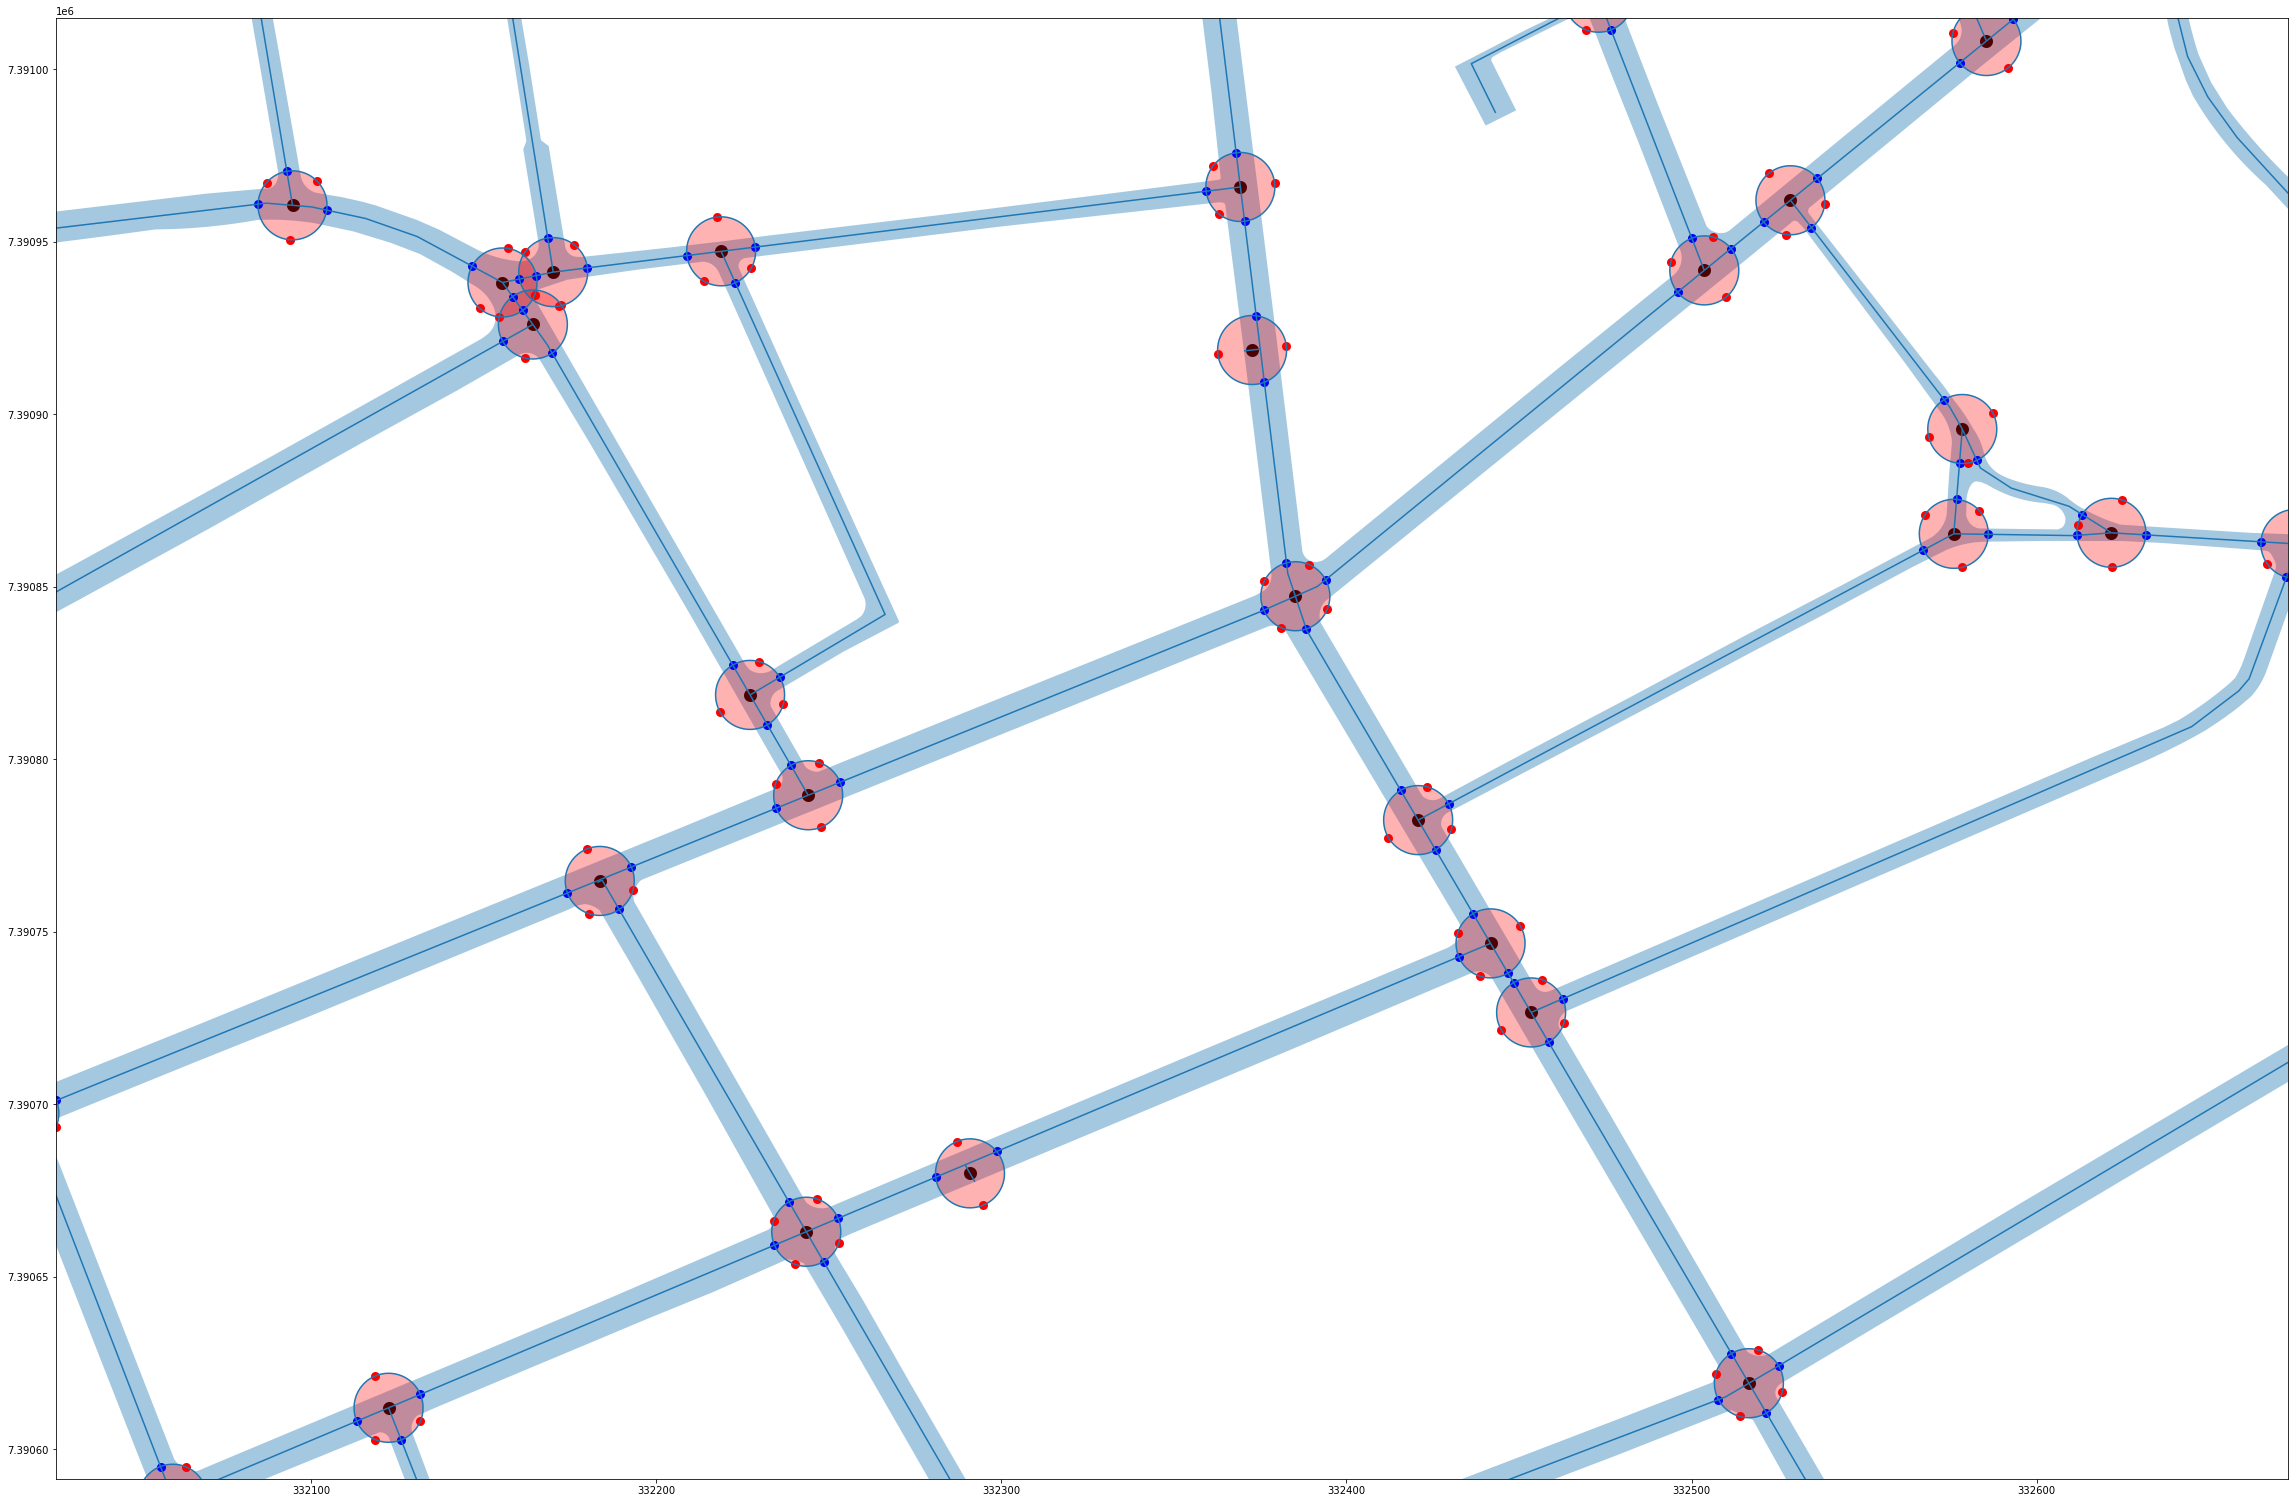

In [27]:
f, ax = plt.subplots(1)
df_vias.plot(ax=ax, alpha=0.4)
df_l.plot(ax=ax)
# df_cruz_buffer.plot(ax=ax, alpha=0.3, color='red')
df_cruzamentos.plot(ax=ax, lw=7, color='black')
df_cruzamentos.buffer(10).plot(ax=ax, alpha=0.3, color='red')
df_bounds.plot(ax=ax)
df_pts.plot(ax=ax, lw=3, color='blue')
df_inter_points.plot(ax=ax, lw=3, color='red')
# Aplicando o zoom
plt.margins(x=-0.30, y=-0.40)

plt.show()

## Criando linhas para 'cortar' os polígonos

Agora que temos que cortar o polígono precisamos de linhas para realizar esse fatiamento. 
Primeiramente vamos criar uma intersecção dos buffers dos nós com o traçado dos logradouros

In [34]:
%time
from shapely.geometry import MultiLineString, LineString
from shapely.affinity import scale

cut_lines = list(map(lambda x:
         scale(
             MultiLineString(list(map(lambda y: 
                  LineString([df_cruzamentos.geometry.iloc[x.Index], y]), 
                  x.geometry.geoms))),
             xfact = 2.0,
             yfact = 2.0,
             origin = df_cruzamentos.geometry.iloc[x.Index])
         , df_inter_points.itertuples()))

df_cut_lines = gpd.GeoDataFrame(geometry=cut_lines)
# df_cut_lines.plot()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.05 µs


In [35]:
df_cut_lines = gpd.clip(df_cut_lines, df_vias_buffered)

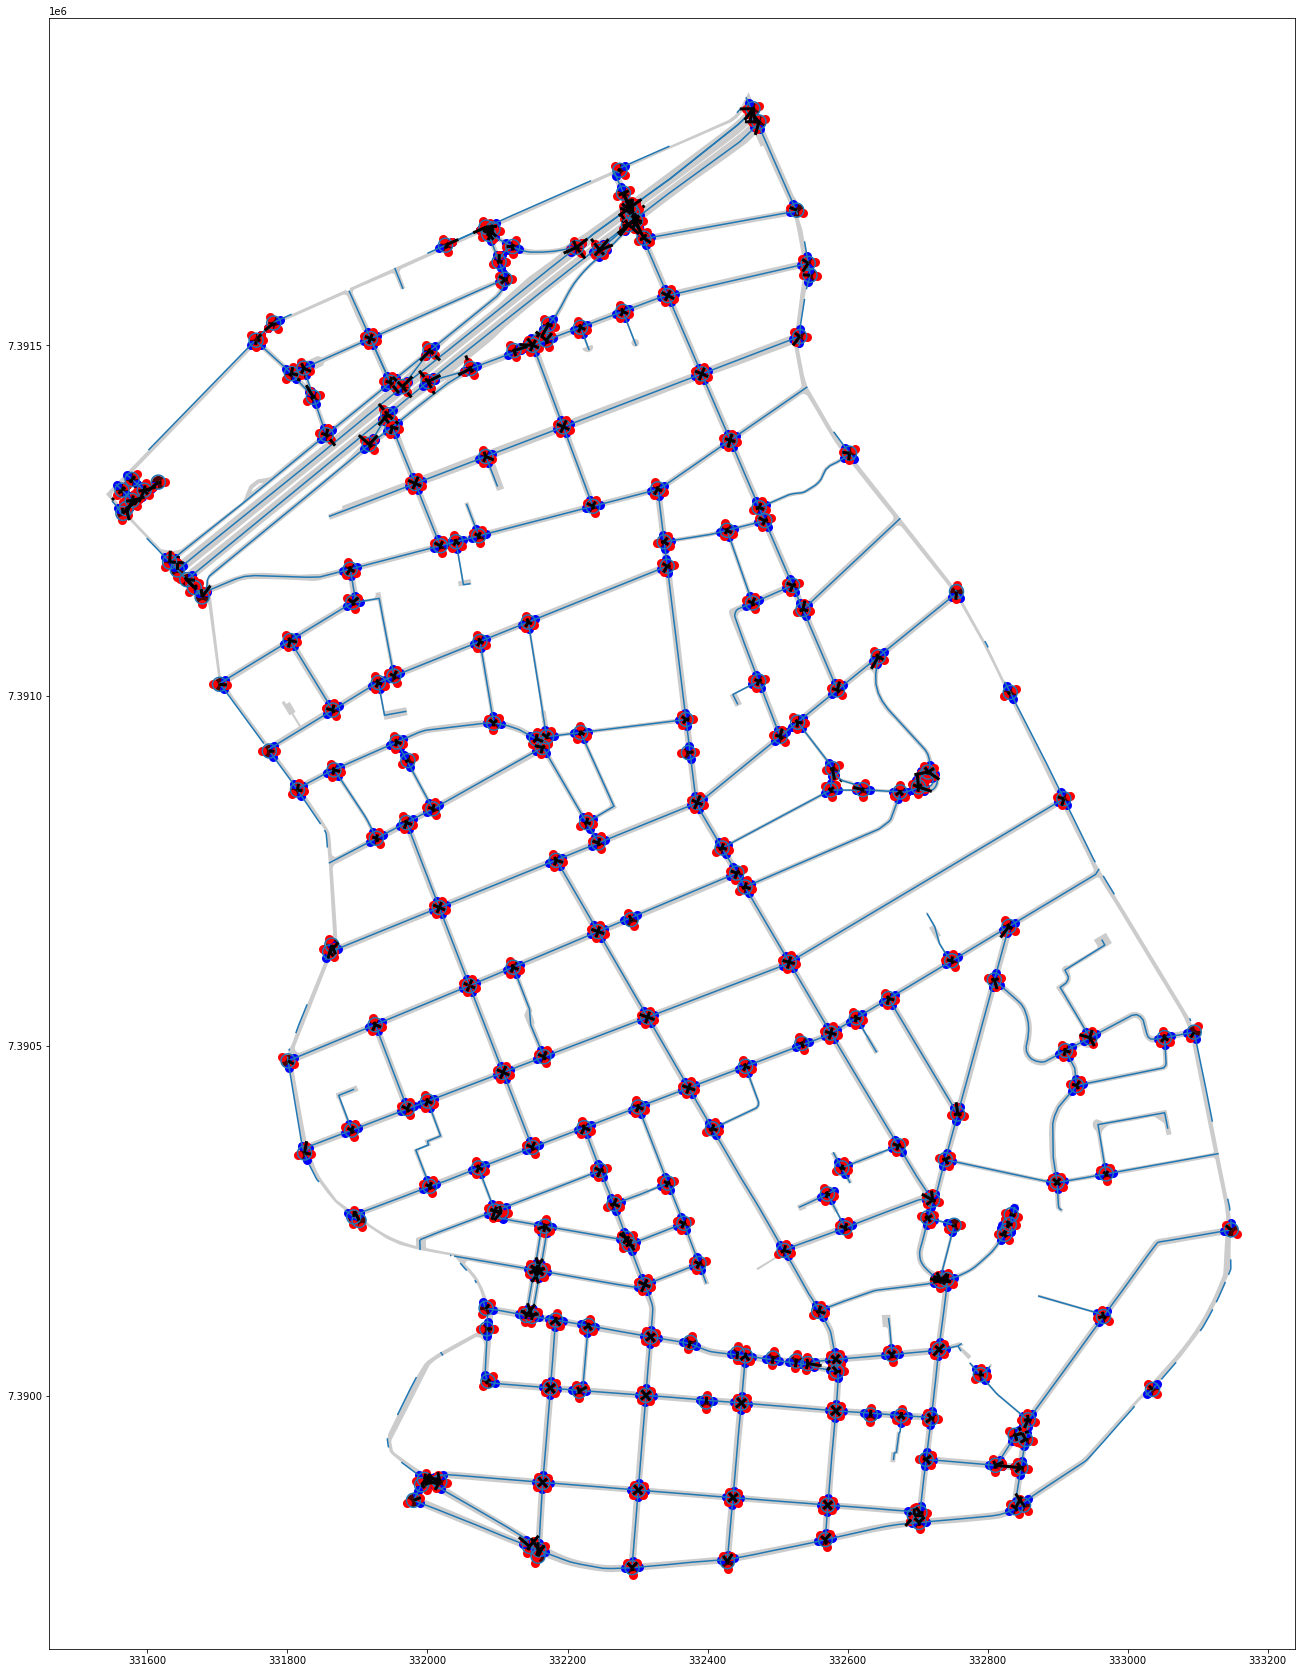

In [36]:
f, ax = plt.subplots(1)
df_vias.plot(ax=ax, alpha=0.4, color='grey')
df_l.plot(ax=ax)
# df_cruz_buffer.plot(ax=ax, alpha=0.3, color='red')
# df_vias_para_corte.plot(ax=ax, alpha=0.4, color='orange', linewidth=1, edgecolor='grey')
df_cruzamentos.plot(ax=ax, lw=7, color='black')
df_cruzamentos.buffer(10).plot(ax=ax, alpha=0.3, color='red')
df_bounds.plot(ax=ax)
df_pts.plot(ax=ax, lw=3, color='blue')
df_inter_points.plot(ax=ax, lw=3, color='red')
df_cut_lines.plot(ax=ax, lw=3, color='black')
# df_voronoi_polygon.plot(ax=ax, alpha=0.7, color='yellow', linewidth=1, edgecolor='grey')
# Aplicando o zoom
# plt.margins(x=-0.30, y=-0.40)


plt.show()

In [37]:
# lp = np.stack((df_l.geometry.interpolate(0.5, normalized=True).to_numpy, 
#                df_l.geometry.interpolate(0.001, normalized=True).to_numpy, 
#                df_l.geometry.interpolate(0.999, normalized=True).to_numpy))

lp = list(map(lambda x: MultiPoint([x.geometry.interpolate(0.5, normalized=True),
                             x.geometry.interpolate(0.001, normalized=True),
                             x.geometry.interpolate(0.999, normalized=True)]),
        df_l[df_l['geometry'].type == 'LineString'].itertuples()))

df_lp = gpd.GeoDataFrame(geometry=lp)
# df_lp


In [38]:
%time
from shapely.ops import cascaded_union, polygonize
df_vias_cutted = polygonize(cascaded_union([df_cut_lines.geometry.unary_union, list(df_vias.geometry.boundary)[0]]))
df_poligonos_de_vias = gpd.GeoDataFrame(geometry = list(df_vias_cutted))
df_poligonos_de_vias.sindex
# df_pvias = df_poligonos_de_vias[df_poligonos_de_vias.geometry.crosses(df_lp.geometry.unary_union)]
df_pvias = df_poligonos_de_vias[df_poligonos_de_vias.geometry.within(df_vias_buffered.geometry.unary_union)]

# df_pvias.plot(color = np.random.rand(len(df_poligonos_de_vias), 3))



CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.05 µs


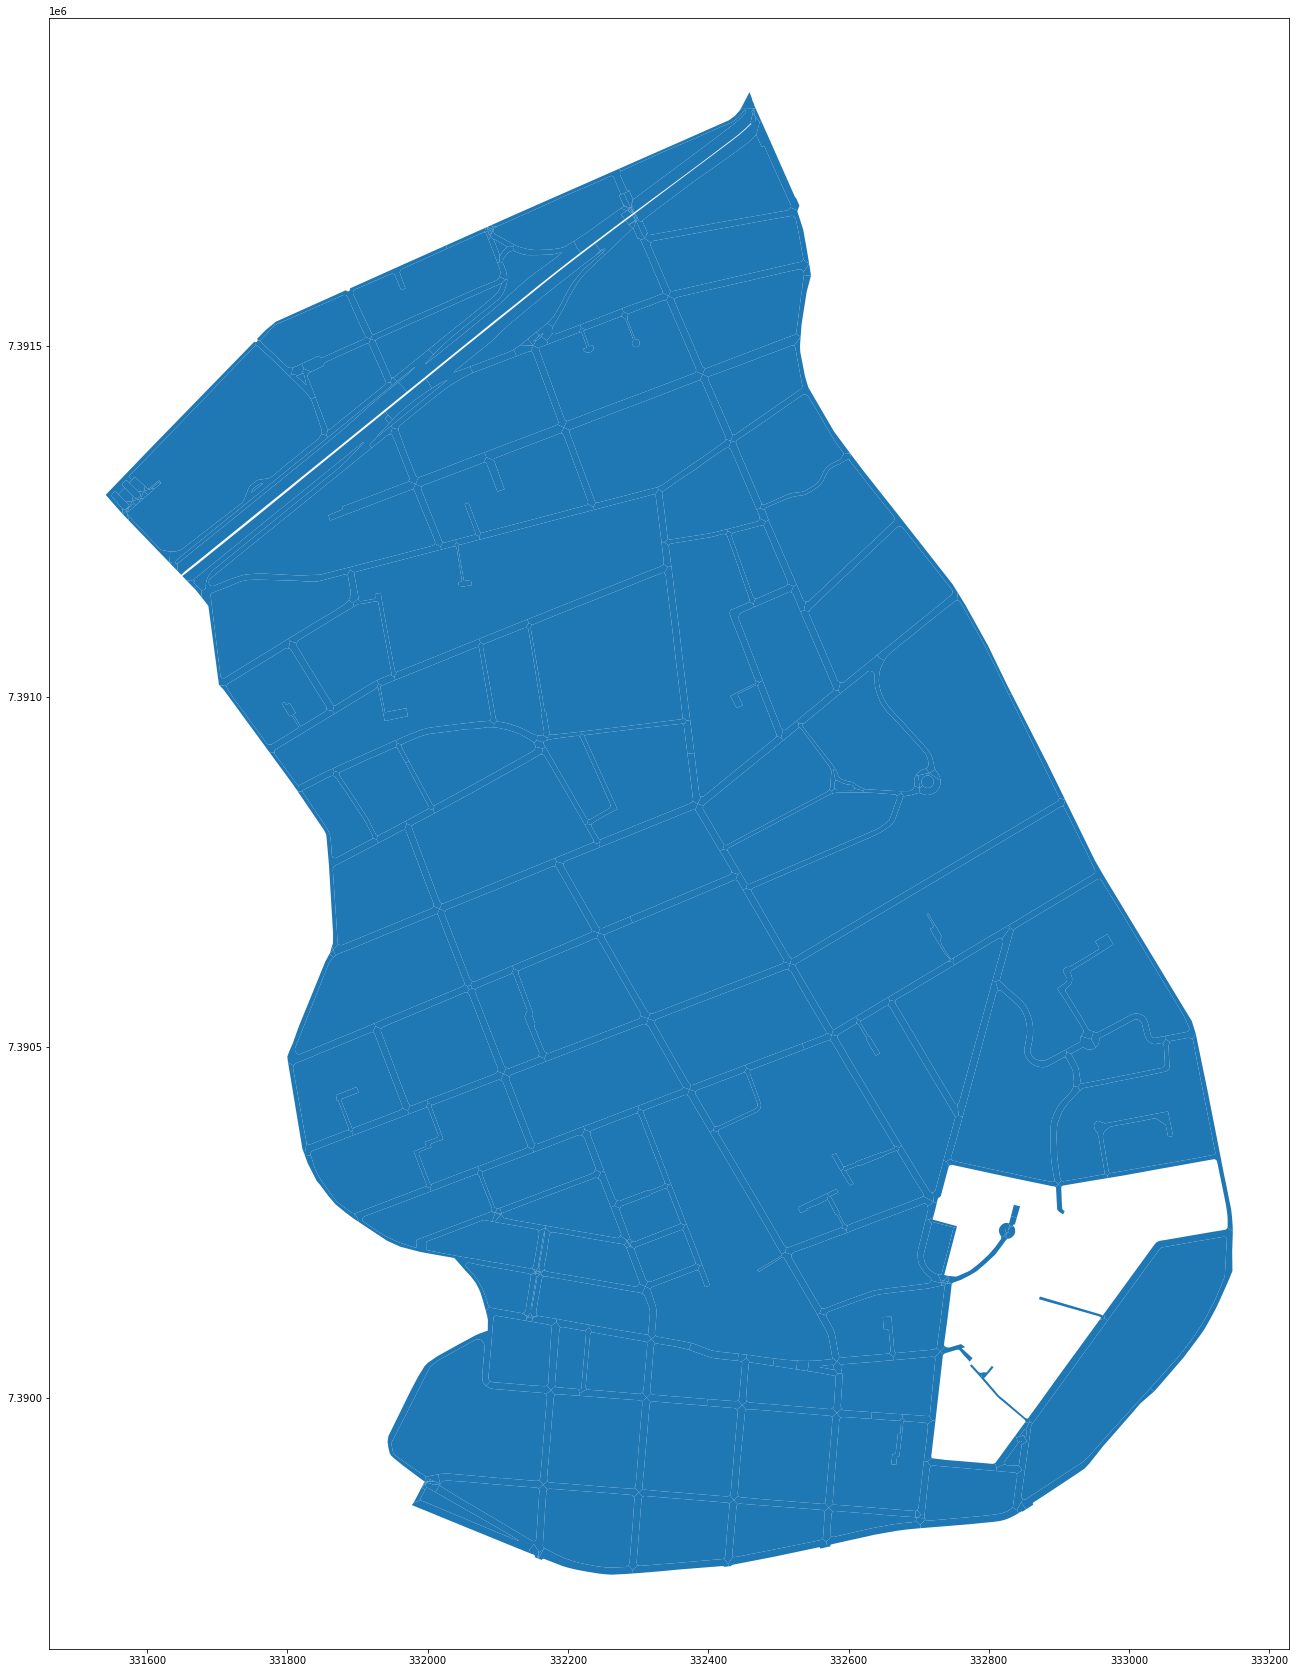

In [39]:
# removendo as massas dágua
df_poligonos_de_vias[df_poligonos_de_vias.disjoint(df_massa_dagua.unary_union)].plot()

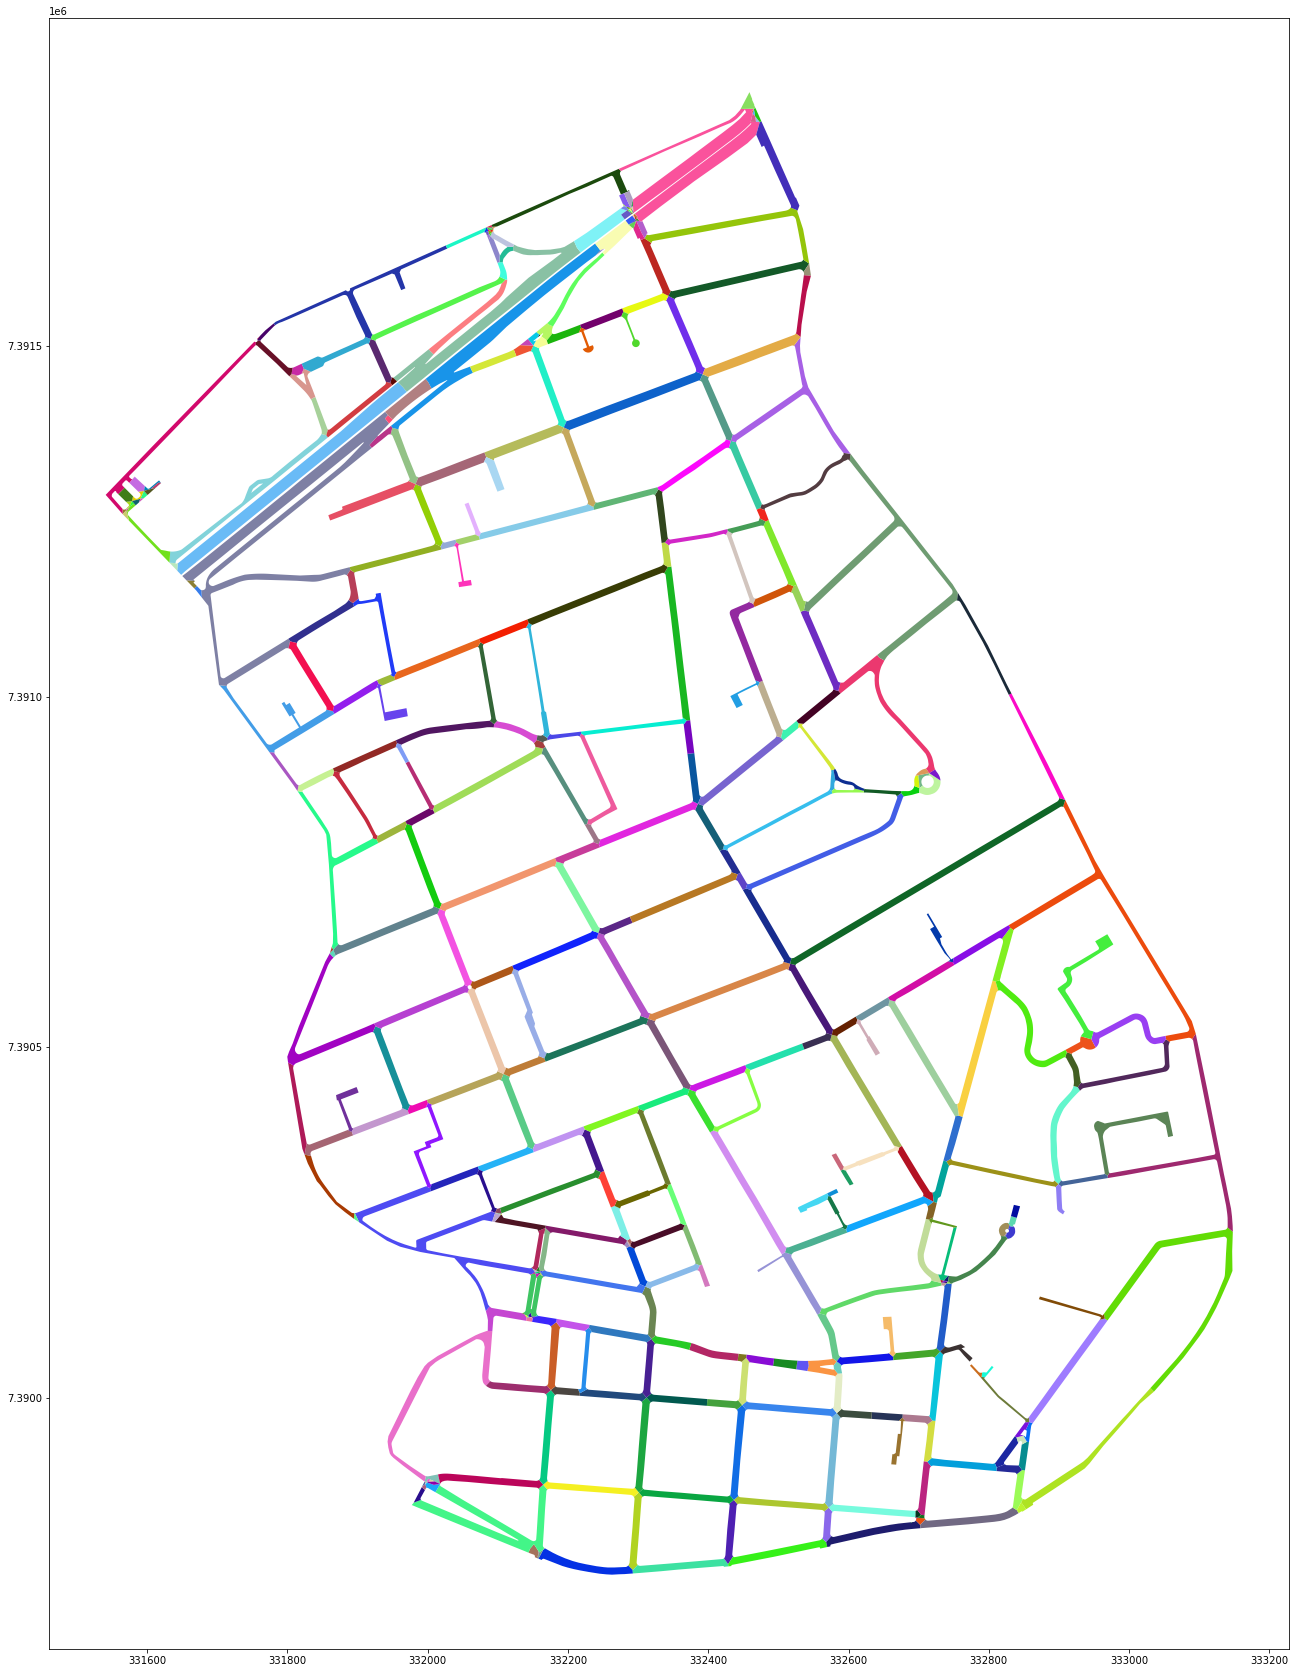

In [40]:
df_pvias.plot(color = np.random.rand(len(df_poligonos_de_vias), 3))

## Salvando o resultado

Agora que temos o polígono de cada via, podemos salvar o resultado para seguir com alguma outra análise como:
- Calcular a largura mínima máxima e média de cada via

In [28]:
# df_pvias.to_file("./resultado/poligono_de_vias.gpkg", layer=f"{list(df_s.ds_codigo)[0]} - poligono de vias de {list(df_s.ds_nome)[0].lower()}", driver="GPKG")